From here on, we will be using the npTensor package which is our dearest tensor library that we built in this repository. 

## Autoencoders

In this notebook, we will be building the Feed Forward Autoencoder achitecture. This architecture is detailed in the adjacent document. Here we will be using our own tensor class written in pure numpy. We are applying our model in MNIST dataset, trying to reconstruct numbers. 

In [1]:
from npTensor import Tensor, FC
import numpy as np
from matplotlib import pyplot as plt

Here, we are designing the architecture to be symmetric about the bottleneck. This is not mandatory, but always preferred. The first and simplest reason is the engineering simplicity. We are able to take a single tuple argument which can initialise both encode and decode layers identically. Second, it makes more sense for the output to be decoded from the latent dimension, the same way as it gets encoded. Why? Imagine we have 10 layers in encoder but only 5 layers in decoder. This adds unecessary complexity in the input side, just for the model to not decode all of it with less number of layers. In our mnist task, all we need is two layers, one encoding, other decoding. 

In [2]:
class FFA:
    def __init__(self, dims):
        self.dims = dims #This is the number of features per layer from input layer to the bottleck. (and back to output layer)
        self.encodeLayers = [FC(self.dims[i], self.dims[i+1]) for i in range(len(self.dims)-1)]
        self.decodeLayers = [FC(self.dims[-(i+1)], self.dims[-(i+2)]) for i in range(len(self.dims)-1)]

    #Simple method to collect the parameters.
    def parameters(self):
        params = []
        for layer in self.encodeLayers:
            params.extend(layer.parameters())
        for layer in self.decodeLayers:
            params.extend(layer.parameters())
        return params
    
    #Using __call__ for inference or prediction. We have an additional flag to peek at latent space. 
    def __call__(self, X: Tensor, retLatentRepresentation = False):

        for layer in self.encodeLayers:
            X = layer(X)

        #Latent Space Representation is obtained after encoding and reducing the dimensions.
        if retLatentRepresentation:
            LatentRepresentation = X

        for layer in self.decodeLayers:
            X = layer(X)

        #We are using sigmoid activation to limit the output in range (0,1).
        #This is becayse the input we're trying to reconstruct here is in the range (0, 1) too after normalization. 
        #Depending on the input, this activation must be swapped for tanh, ReLU etc.
        #We may introduce a parameter for activaiton selection.

        #X = X.tanh()
        #X = X.ReLU()
        X = X.sigmoid()
        
        if retLatentRepresentation:
            return X, LatentRepresentation
        
        return X
    
    def save_model(self, filename="MNIST_Autoencoder.npz"):
        weights_dict = {}
        for i, param in enumerate(self.parameters()):
            weights_dict[f'param_{i}'] = param.matrix
        
        np.savez(filename, **weights_dict)
        print(f"Model saved to {filename}")

    def load_model(self, filename="MNIST_Autoencoder.npz"):
        loaded_data = np.load(filename)
        for i, param in enumerate(self.parameters()):
            if param.shape == loaded_data[f'param_{i}'].shape:
                param.matrix= loaded_data[f'param_{i}']
            else:
                raise ValueError(f"Shape Mismatch at index {i}: Model expects {param.shape}, loaded {loaded_data[f'param_{i}'].shape}")
    
    @staticmethod
    def adam_step(params, adam_state, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        for i, p in enumerate(params):
            if p.grad is None:
                continue
            state = adam_state[i]
            if not state:
                state['m'] = np.zeros_like(p.grad)
                state['v'] = np.zeros_like(p.grad)
                state['t'] = 0
            state['t'] += 1
            state['m'] = beta1 * state['m'] + (1 - beta1) * p.grad
            state['v'] = beta2 * state['v'] + (1 - beta2) * (p.grad ** 2)
            m_hat = state['m'] / (1 - beta1 ** state['t'])
            v_hat = state['v'] / (1 - beta2 ** state['t'])
            p.matrix -= lr * m_hat / (np.sqrt(v_hat) + eps)

    #Simple enough. Basically, call, calculate closs, print loss, optimize, zero grad, and repeat.
    def train(self, X: Tensor, epochs=20, learning_rate=0.01):
        losses = []
        params = self.parameters()
        adam_state = [{} for _ in params]

        #No batching.
        for epoch in range(epochs):
            out = self(X)
            N = X.shape[0]
            loss = ((out - X)**2).mean(axis=-1).sum()/N
            loss.backward()

            print(f"Epoch: {epoch} | Loss: {loss}")

            losses.append((epoch, loss.matrix.item()))

            FFA.adam_step(params, adam_state, lr=learning_rate)

            #Zero Grad-ing and cleaning the computational graph.
            for param in params:
                param.zero_grad()
                param.cleanBackward()

            #Clearning the loss computational graph and also deleting the unused tensors
            loss.cleanBackward()
            del loss, out
        
        return losses


In [3]:
import os
os.environ['KERAS_BACKEND'] = 'jax'
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Normalizing the input to 0-1.
X_train = (X_train.astype(np.float32).reshape(-1, 784) / 255.0)
X_test = X_test.astype(np.float32).reshape(-1, 784) / 255.0

#This part is not required since we dont want to classify the digits.
'''
Y_train = np.zeros((y_train.size, 10))
Y_train[np.arange(y_train.size), y_train] = 1
Y_test = np.zeros((y_test.size, 10))
Y_test[np.arange(y_test.size), y_test] = 1'''

#Not needed.
del y_train, y_test

/Users/pawanadhikari/Documents/Roadmap/MachineLearningMaths/.venv/lib/python3.14/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [5]:
X_test.shape

(10000, 784)

Thus we have 784 input features. We need to compress these features down to the latent space with far less number of features/dimensions. (eg. 32,64 or 128)

In [4]:
test = FFA(
    dims=(784, 64, )
)

out, latent = test(X_test[1], True)
print(f"out.shape: {out.shape}")
print(f"latent.shape: {latent.shape}")

out.shape: (1, 784)
latent.shape: (1, 64)


In [7]:
X_train.shape

(60000, 784)

In [15]:
losses = test.train(X=Tensor(X_train[:10000]), epochs=50, learning_rate=0.001)

Epoch: 0 | Loss: Tensor Values = [[0.01344959]]


ValueError: non-broadcastable output operand with shape (1,64) doesn't match the broadcast shape (0,64)

In [10]:
test.save_model("MNIST_Autoencoder_FULL.npz")

'''weights_dict = {}
for i, param in enumerate(test.parameters()):
    weights_dict[f'param_{i}'] = param.matrix

np.savez("MNIST_Autoencoder_02.npz", **weights_dict)
print(f"Model saved to {"MNIST_Autoencoder_02.npz"}")'''

Model saved to MNIST_Autoencoder_04.npz


'weights_dict = {}\nfor i, param in enumerate(test.parameters()):\n    weights_dict[f\'param_{i}\'] = param.matrix\n\nnp.savez("MNIST_Autoencoder_02.npz", **weights_dict)\nprint(f"Model saved to {"MNIST_Autoencoder_02.npz"}")'

In [5]:
test.load_model("MNIST_Autoencoder_04.npz")

In [17]:
inputs = X_test[1:11]
testim, latent = test(input, True)
print(f"out.shape: {testim.shape}")
print(f"latent.shape: {latent.shape}")

out.shape: (1, 784)
latent.shape: (1, 64)


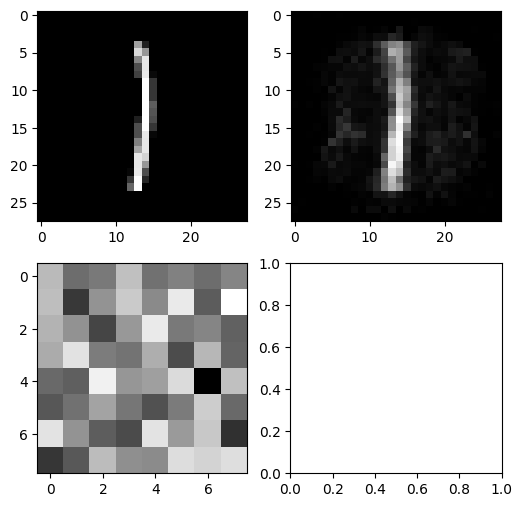

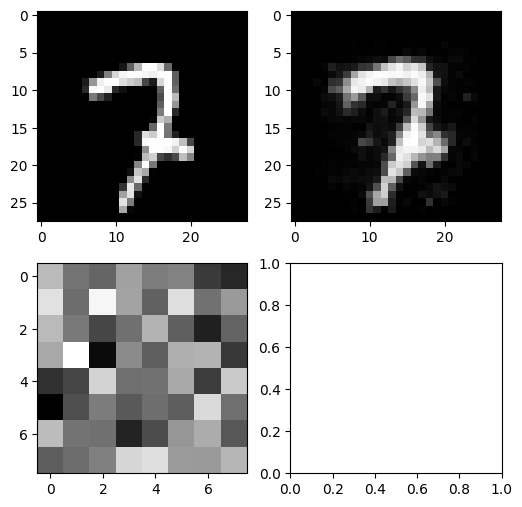

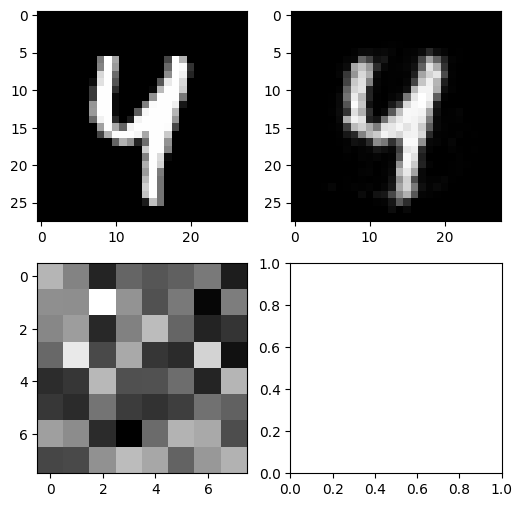

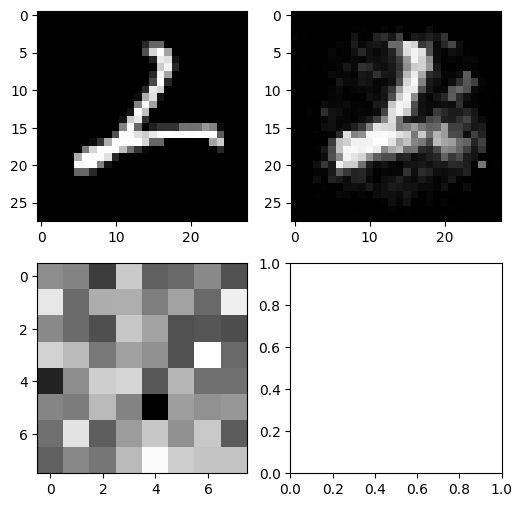

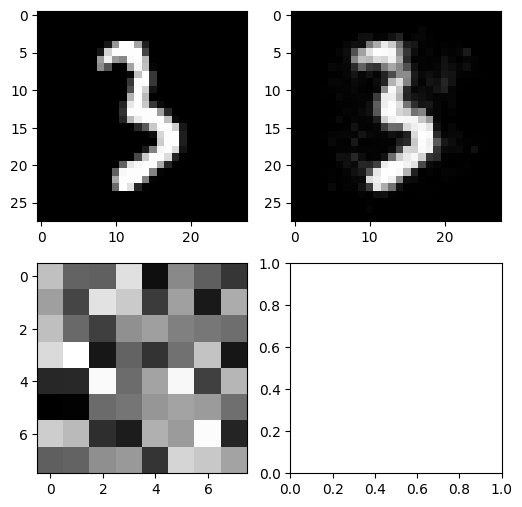

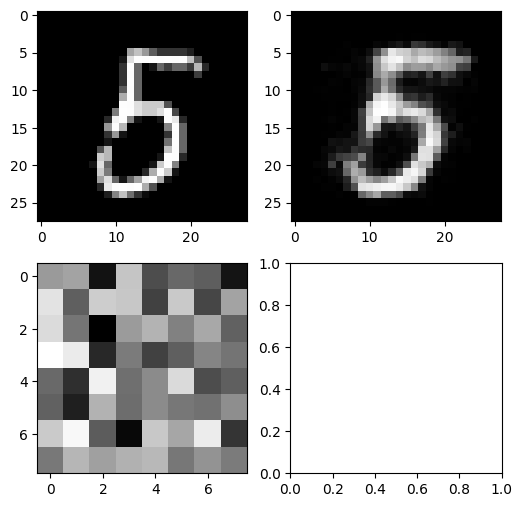

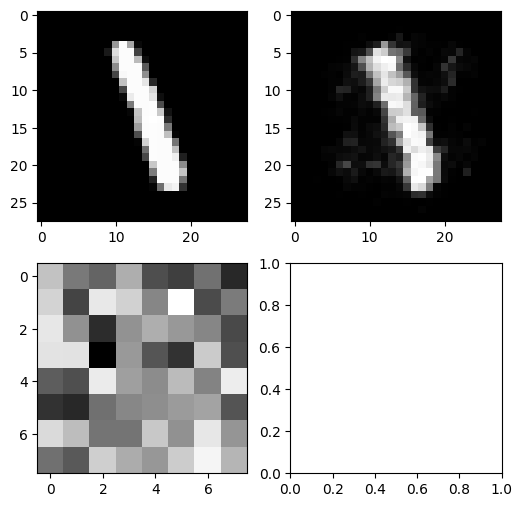

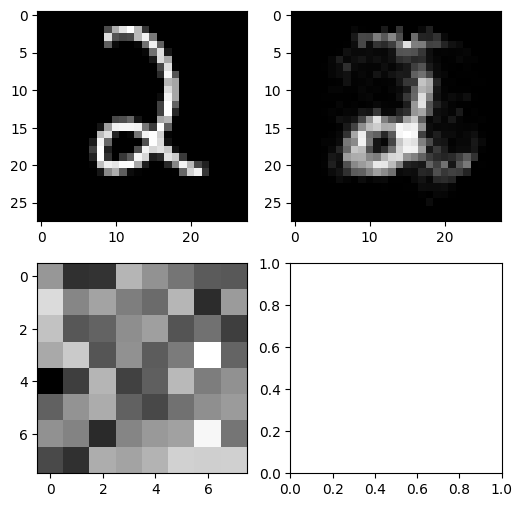

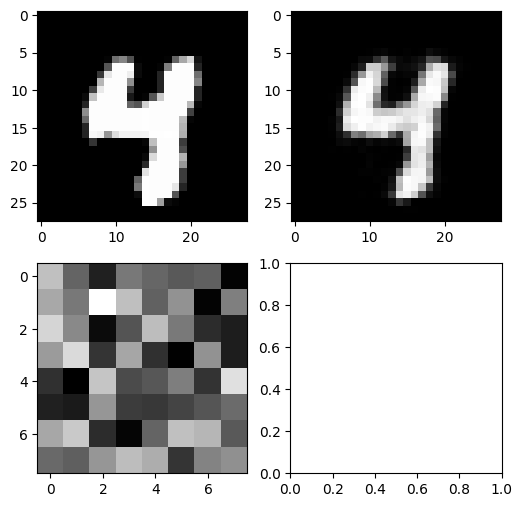

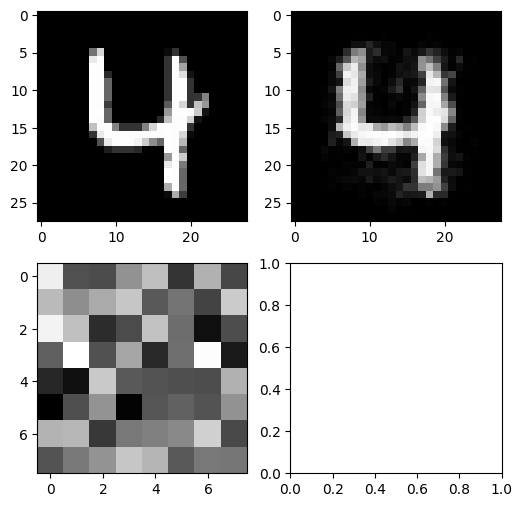

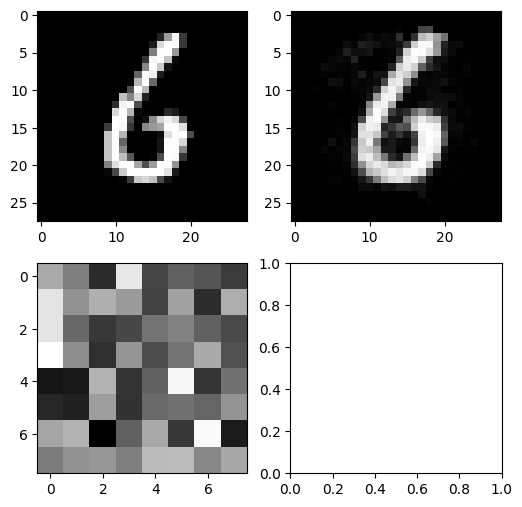

In [7]:
inputs = X_test[40:51]
for input in inputs:
    testim, latent = test(input, True)

    testim = testim.reshape((28, 28, ))
    latent = latent.reshape((8, 8, ))

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))
    ax[0,0].imshow(input.reshape(28, 28), cmap='gray')
    ax[0,1].imshow(testim.matrix, cmap='gray')
    ax[1,0].imshow(latent.matrix, cmap='gray')

plt.show()

In [12]:
print(testim)
print(input)

Tensor Values = [[1.76733010e-03 1.48577004e-04 2.45804107e-03 3.95787274e-03
  1.12085289e-03 2.54237908e-03 3.70304775e-03 1.70662149e-03
  6.72980153e-04 1.79493567e-03 1.03980675e-03 5.99570689e-04
  9.55968746e-04 3.40256235e-03 5.03132644e-04 6.57027471e-04
  3.09138093e-04 7.80268223e-04 1.63031125e-03 3.08311632e-04
  1.15564547e-03 1.56733871e-03 1.15343754e-03 1.83928048e-03
  1.08484004e-03 2.70018983e-03 2.33057188e-04 3.63256782e-04]
 [2.58886575e-04 2.59396562e-04 1.24118838e-03 8.67375813e-04
  1.75129142e-04 1.68719664e-04 1.75027247e-03 1.74510549e-03
  1.27016695e-03 2.98383459e-03 2.95432197e-04 3.16537567e-03
  6.70022855e-04 2.15189392e-03 1.16633356e-03 1.36251445e-04
  5.20302868e-03 1.14572502e-03 7.67878315e-04 7.90896360e-04
  8.27092968e-04 4.09743981e-04 5.18314599e-04 1.74529420e-03
  2.01446048e-04 8.62513261e-04 1.13716675e-03 7.61528674e-04]
 [1.47999637e-03 2.34057335e-03 6.43380161e-04 1.69654365e-03
  1.88462218e-04 7.20819458e-04 6.74128823e-04 2.782

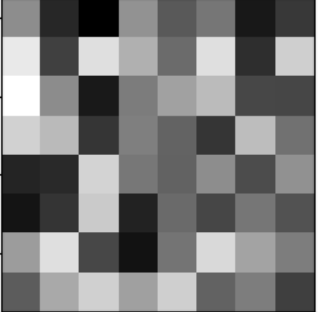
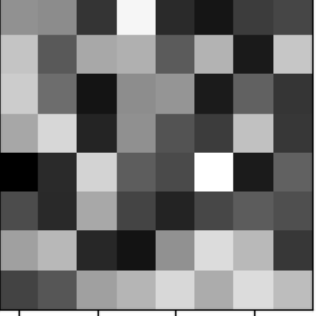
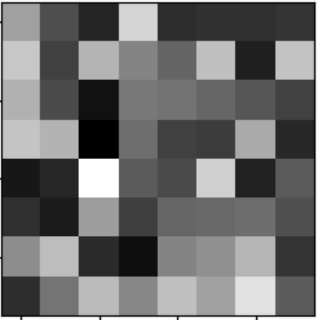
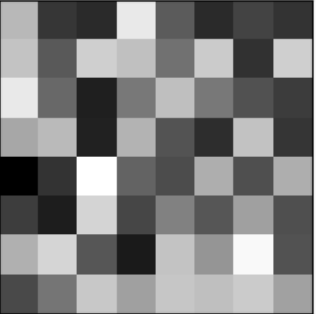
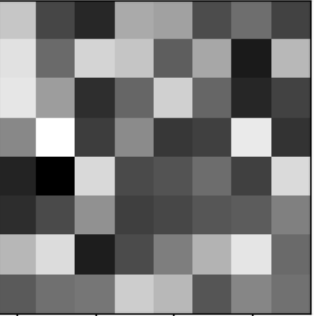
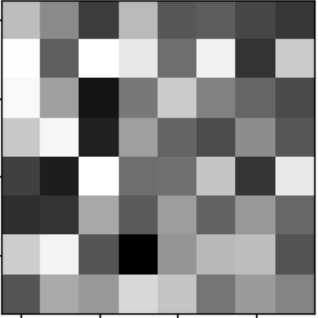
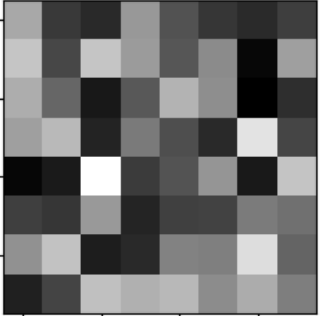
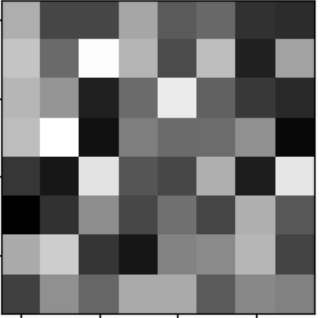
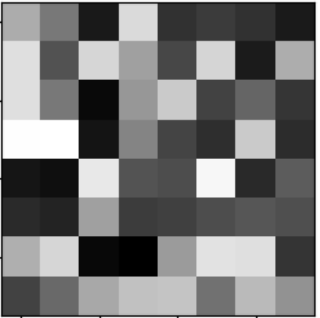
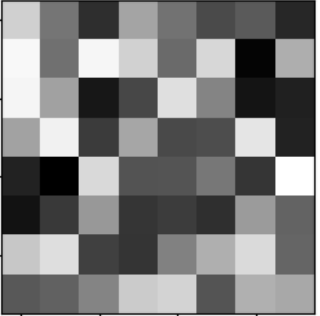


This is All the latent space representations for all numbers from 0-9. So fascinating! The patterns remain same but the intensity of pixels differ as per the digit. 